In [1]:
"""
Brian Sharber
CSCI 4350/5350
Dr. Joshua Phillips
Honors Contract: Fall 2019
Program Description: Fine-tunes Gamma for use in Subspace-Clustering.ipynb.
The third cell is replaceable with the dataset you're wanting to fine-tune.
"""

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
import math
from cvxpy import *
import numpy as np
import scipy.spatial.distance as sdist
from sklearn.cluster import KMeans
from math import *

In [2]:
# Ground truth
f = open("ground.in", "w+")
for x in range(100):
    f.write(' {:0d}\n'.format(0))

for x in range(100):
    f.write(' {:0d}\n'.format(1))

f.close()
# Convert the floating text in the file to integers when they come in
Xassign = np.loadtxt("ground.in").astype(np.int32)
#print(ground)

In [3]:
# Make some toy data sets
# Set 1: 2 horizontal lines: 0 < y < 1
count = 0.1
f = open("lines-1.in", "w")
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(0))
    count += 0.1
    
count = 0.1
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(1))
    count += 0.1

f.close()
X = np.loadtxt("lines-1.in")

Max Mutual Information so far
0.0012846151463807064
Matching gamma 0.001


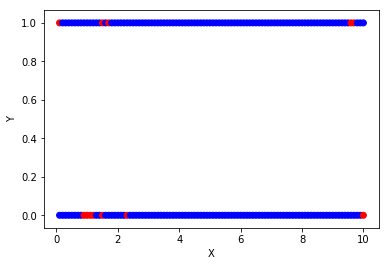

Max Mutual Information so far
0.02630303774743224
Matching gamma 0.006


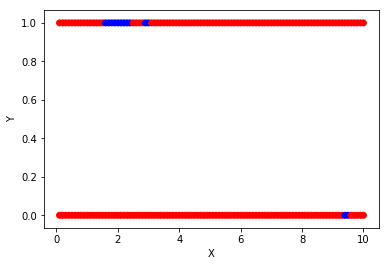

Max Mutual Information so far
0.09868447484771829
Matching gamma 0.011


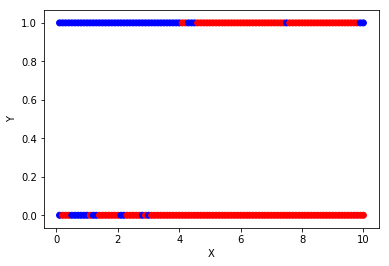

Max Mutual Information so far
0.10803154614554838
Matching gamma 0.026000000000000002


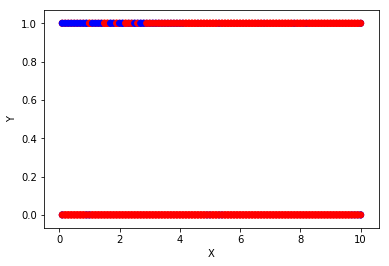

Max Mutual Information so far
0.21555782509145527
Matching gamma 0.036000000000000004


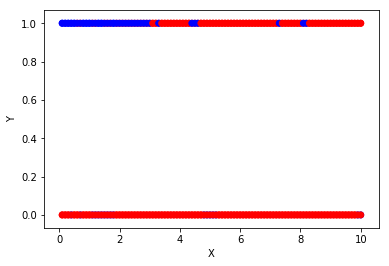

Max Mutual Information so far
0.928991170481842
Matching gamma 0.041


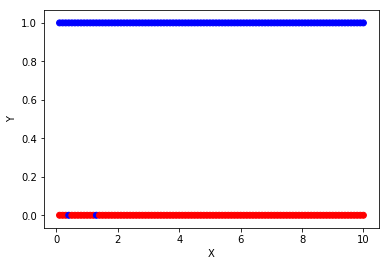

Max Mutual Information so far
0.9999999999998976
Matching gamma 0.046


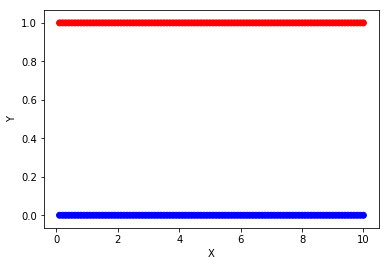

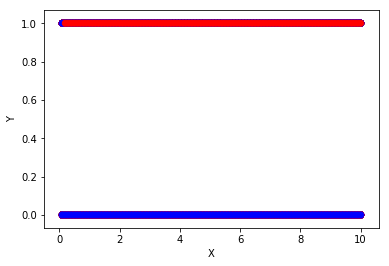

In [4]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

## Set affinity scaling factor
sigma = .01
a = 0
max = 0

for x in range(100):

    A = np.transpose(X)
    Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
    for i in range(np.shape(A)[1]):
        b = A[:,i]
        # gamma must be positive due to DCP rules.
        gamma = Parameter(nonneg="true")
        constraints = None

        # Construct the problem.
        x = Variable(np.shape(A)[1])

        ## Lasso
        obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
        constraints = [x[i] == 0]
        ## constraints = [x[i] == 0, sum(x) == 1]

        ## L1-Perfect
        ## obj = Minimize(norm(x, 1))
        ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
        ## L1-Noisy
        ## obj = Minimize(norm(x, 1))
        ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

        if [constraints == None]:
            prob = Problem(obj)
        else:
            prob = Problem(obj,constraints)

        ## From the original code
        #gamma.value = 0.001
        gamma.value = 0.001 + a
        prob.solve(solver='ECOS')

        Coeff[:,i] = np.transpose(x.value)
    #print(Coeff.shape)

    ## Refine results...
    ## Only use magnitude of the coefficients (no negative values)
    Coeff = np.abs(Coeff)
    ## Normalize each row - not needed but doesn't hurt on most examples
    ## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
    ## Symmetrize
    Coeff = Coeff + np.transpose(Coeff)

    ## Dimensions in each subspace
    d1 = 1
    d2 = 1

    ## What is K?
    K = np.max([d1,d2])+1
    #print(K)

    ## Select the top K coefficients
    newCoeff = np.zeros(np.shape(Coeff))
    indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
    for x in range(np.shape(Coeff)[0]):
        newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

    ## Normalize each row - again, not really needed
    ## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
    ## Symmetrize
    newCoeff = newCoeff + np.transpose(newCoeff)

    ## Standard...
    Xaff = newCoeff

    ## Get row sums
    Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

    ## Normalization
    Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

    ## Decomposition
    Evals, Evecs = np.linalg.eigh(Xnorm)

    #Xnorm1 = Xnorm
    Xaff1 = Xaff

    ## Perform clustering
    Xnew = Evecs[:,[-1,-2]]
    kmeans = KMeans(n_clusters=2).fit(Xnew)

    ## If you want to see the eigen vectors...
    ## Xone = Evecs[kmeans.labels_==0,:]
    ## Xtwo = Evecs[kmeans.labels_==1,:]
    ## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

    ## If you want it on the PCA projection...
    #Xone = Xsvd[0][kmeans.labels_==0,:]
    #Xtwo = Xsvd[0][kmeans.labels_==1,:]
    #plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

    ## Let's quantify the performance
    jointPDF = np.zeros([2,2])
    for x in range(len(Xassign)):
        jointPDF[Xassign[x],kmeans.labels_[x]] += 1
    jointPDF /= len(Xassign)
    jointPDF += 0.000000000000001
    marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))

    # Plot the Subspace clustering attempt at the data
    # Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
    plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
    plt.ylabel('Y')
    plt.xlabel('X')
    sigma += 0.02
    a += .005
    if np.sum(jointPDF*np.log2(jointPDF/marginals)) > max:
        max = np.sum(jointPDF*np.log2(jointPDF/marginals))
        print('Max Mutual Information so far')
        print(max)
        print("Matching gamma", gamma.value)
        plt.show()